<a href="https://colab.research.google.com/github/Andreas-Lukito/Image-Disaster-Classification/blob/main/Image_disaster_classification_colab_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Disaster Classification

In this project, a deep learning model will be developed from scratch to classify images into disaster and non-disaster categories, using a dataset sourced from Kaggle. To optimize the architecture within this limit, Optuna will be used to perform hyperparameter tuning through grid search. The objective is to design an efficient and accurate model architecture that balances performance and complexity.

## Install Libraries

In [1]:
!pip install optuna
!pip install pynvml
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install sklearn
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 116.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitl

## Import Libraries

In [2]:
# Common python libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pynvml
import cv2
import os
import glob
from tqdm import tqdm
import pickle
import shutil
import random
import math
import copy
from PIL import ImageFile

# Deep Learning Libraries
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Hyper Parameter Tuning
import optuna
from optuna.exceptions import TrialPruned
from optuna.trial import TrialState

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

# Model Evaluation
from sklearn.metrics import f1_score


## GPU Check

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Pytorch is using the GPU")

    import pynvml
    pynvml.nvmlInit()

    num_gpus = pynvml.nvmlDeviceGetCount()

    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    pynvml.nvmlShutdown()
else:
    print("Pytorch is not using the GPU")

Pytorch is using the GPU
GPU Name: Tesla T4


In [4]:
print("Num GPUs Available: ", torch.cuda.device_count())

Num GPUs Available:  1


## Set Random Seed

setting the seed for consistency

In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Reorganizing and Cleaning the Images

Since the dataset includes many categories, it is best to consolidate them into the following:
```"Damaged_Infrastructure", "Damaged_Water", "Drought", "Fire_Urban", "Fire_Wildlife_Forest", "Injured_Human", "Land_Slide", "Non_Damage_Infrastructure", "Non_Damage_Sea", "Non_Damage_Wildlife_Forest", "Uninjured_Human".```

Due to the similarities between earthquake-related damage and other forms of infrastructure damage, distinguishing between them—especially in images—is often difficult. Additionally, some images are mislabeled or placed in the wrong categories.

To address this, most images will be manually reorganized to ensure accurate classification. Images that contain multiple scenes in a single frame (e.g. a collage of four images arranged in a grid) will be separated into individual images. Furthermore, damaged automobiles will be included under the "Damaged_Infrastructure" category.

The final organized dataset will reflect these changes and can be seen <a href="https://drive.google.com/drive/folders/1F-LuyODIFm013xZXS4nCWTy2CJ0TtRjq?usp=sharing">here</a>.

## Import the data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def img_to_df(img_path: str):
    """
    Convert image paths to DataFrame. for easier data preprocessing.

    Args:
        img_path (str): Path to the folder containing the image.

    Returns:
        pd.DataFrame: DataFrame containing image path, label, width, height, and channel_info.
    """
    #checks
    if not isinstance(img_path, str):
        raise TypeError("img_path must be a string.")
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"The path {img_path} does not exist.")
    if not os.path.isdir(img_path):
        raise NotADirectoryError(f"The path {img_path} is not a directory.")

    # Get the list of all image files in the directory
    glob_path = os.path.join(img_path, "**", "*.png")
    print(f"glob_path: {glob_path}")

    image_path = glob.glob(glob_path, recursive=True) #recursive=True is to allow for subdirectories to be searched
    print(f"image_path: {image_path}")

    # Get the label from the directory name
    labels = []
    for path in tqdm(image_path, desc="Extracting labels", unit="image"):
        labels.append(path.split("/")[-2])

    # Get the width, height, and channel information of the images
    width = []
    height = []
    channel_info = []
    avg_red = []
    avg_green = []
    avg_blue = []

    for path in tqdm(image_path, desc="Processing images", unit="image"):
        img = cv2.imread(path)
        if img is None:
            print(f"Skipping corrupted image: {path}")
            continue

        h, w, c = img.shape
        average = img.mean(axis=0).mean(axis=0)

        # Append to the list
        height.append(h)
        width.append(w)
        channel_info.append(c)
        avg_blue.append(average[0])
        avg_green.append(average[1])
        avg_red.append(average[2])


    #combine into one dataframe
    df = pd.DataFrame({
        "image_path": image_path,
        "label": labels,
        "width": width,
        "height": height,
        "channel_info": channel_info,
        "img_avg_red": avg_red,
        "img_avg_green": avg_green,
        "img_avg_blue": avg_blue
    })

    return df

### Caching function to load it faster

In [8]:
def save_cache(data, filename):
    """This is a function to save the data to a file using pickle

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to save the data to
    """
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Data saved to {filename}")

def load_cache(filename):
    """This is a function to load the data to a file using pickle

    Args:
        data (_type_): data to be saved
        filename (_type_): the name of the file to load the data to
    """
    with open(filename, 'rb') as f:
        return pickle.load(f)
    print(f"Data loaded from {filename}")

In [9]:
data_path = "/content/drive/MyDrive/project_Disaster classification/organized_data"
write_path = "/content/drive/MyDrive/project_Disaster classification/Cache/"

if not os.path.exists(write_path):
            os.makedirs(write_path)

csv_path = os.path.join(write_path, "path_dataset.csv")

# We will cache the data so that it will load faster
if os.path.exists(csv_path):
    print("Loading cached dataset...")
    img_df = pd.read_csv(csv_path)
    print("Cached dataset loaded")
else:
    print("Creating and caching dataset...")
    img_df = img_to_df(data_path)
    img_df.to_csv(csv_path, index=False)

Loading cached dataset...
Cached dataset loaded


In [10]:
img_df.head()

,Unnamed: 0,image_path,label,width,height,channel_info,img_avg_red,img_avg_green,img_avg_blue
0,0,/content/drive/MyDrive/project_Disaster classi...,Damaged_infrastructure,1080,597,3,109.362026,90.761479,89.291510
1,1,/content/drive/MyDrive/project_Disaster classi...,Damaged_infrastructure,403,485,3,104.930649,94.591210,95.495290
2,2,/content/drive/MyDrive/project_Disaster classi...,Damaged_infrastructure,640,640,3,142.472825,139.719290,136.047327
3,3,/content/drive/MyDrive/project_Disaster classi...,Damaged_infrastructure,1080,720,3,121.107927,123.925171,116.233974
4,4,/content/drive/MyDrive/project_Disaster classi...,Damaged_infrastructure,1080,1080,3,90.767231,88.903693,96.512079


## EDA

### Plotting Functions

In [11]:
#setting the colors generator
def fill_color_generator():
    """This generates a color

    Returns:
        color: An R,G,B value with a range of 0 to 1
    """
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return (r/255, g/255, b/255)

In [12]:
#function for plotting numerical data distribution
def numeric_dist_plot(data: pd.DataFrame):
    """This function creates a plot of the distribution of the numerical data.

    Args:
        data (pd.DataFrame): Numeric pandas dataframe

    Raises:
        TypeError: The following columns are not numeric: {non_numeric_cols}
        This is due to some of the columns are not numeric.

    Returns:
        Displays a plot of
    """
    # Checks
    ## Check if all columns are numeric
    non_numeric_cols = [col for col in data.columns if not pd.api.types.is_numeric_dtype(data[col])]
    if non_numeric_cols:
        raise TypeError(f"The following columns are not numeric: {non_numeric_cols}")

    # Plotting the numerical data
    #titles for plots/figures
    fig_titles = []

    for colName in data.columns:
        fig_titles.append(f"Boxplot Of {colName}")
        fig_titles.append(f"Histogram Of {colName}")

    fill_color_dict = {}
    for colName in data.columns:
        fill_color_dict[colName] = fill_color_generator()

    # make subplot for each column name
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, num_rows * 3))

    # Flatten axes for easier indexing when there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    for i, column in enumerate(data.columns):
        color = fill_color_dict[column]

        # Boxplot
        axes[i][0].boxplot(data[column].dropna(), vert=False, patch_artist=True,
                        boxprops=dict(facecolor=color, color=color),
                        medianprops=dict(color="black"))
        axes[i][0].set_title(f"Boxplot of {column}")
        axes[i][0].set_xlabel(column)

        # Histogram
        axes[i][1].hist(data[column].dropna(), bins=20, color=color, alpha=0.7, edgecolor='black')
        axes[i][1].set_title(f"Histogram of {column}")
        axes[i][1].set_xlabel(column)

    # Overall layout
    fig.suptitle("Boxplot and Distribution Visualization for Each Numeric Column", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
    return plt

In [13]:
#function for plotting categorical data distribution
def categoric_dist_plot(data: pd.DataFrame):
    """_summary_

    Args:
        data (pd.DataFrame): Categorical pandas dataframe

    Raises:
        TypeError: The following columns are not categorical: {non_numeric_cols}
        This is due to some of the columns are not categorical.

    Returns:
        plt: Plot of the categorical data distribution
    """
    # Checks
    ## Check if all columns are numeric
    non_categoric_cols = [col for col in data.columns if pd.api.types.is_numeric_dtype(data[col])]
    if non_categoric_cols:
        raise TypeError(f"The following columns are not categoric: {non_categoric_cols}")

    # Create subplots: one row for each categorical column
    num_rows = len(data.columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(20, 75), sharex=False)

    # Flatten axes for easier handling if there's more than 1 row
    axes = axes if num_rows > 1 else [axes]

    # Plot each categorical distribution
    for i, col in enumerate(data.columns):
        counts = data[col].value_counts(dropna=False)  # Get the count values
        counts.index = counts.index.astype(str) #convert the categorical values to strings since there are numerical categories

        #Create the bar plot
        axes[i].bar(counts.index, counts)

        # Set title and labels
        axes[i].set_title(f"{col}", fontsize=12)
        axes[i].set_ylabel("Count")
        axes[i].set_xlabel("Category")

        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=90)

    # Add an overall title and adjust layout
    fig.suptitle("Bar Plots for Categorical Columns", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=2.0)  # Adjust spacing between rows
    return plt

### Plotting Numerical Data

In [14]:
numeric_data = img_df.select_dtypes(include=[np.number])
numeric_data.columns

Index(['Unnamed: 0', 'width', 'height', 'channel_info', 'img_avg_red',
       'img_avg_green', 'img_avg_blue'],
      dtype='object')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

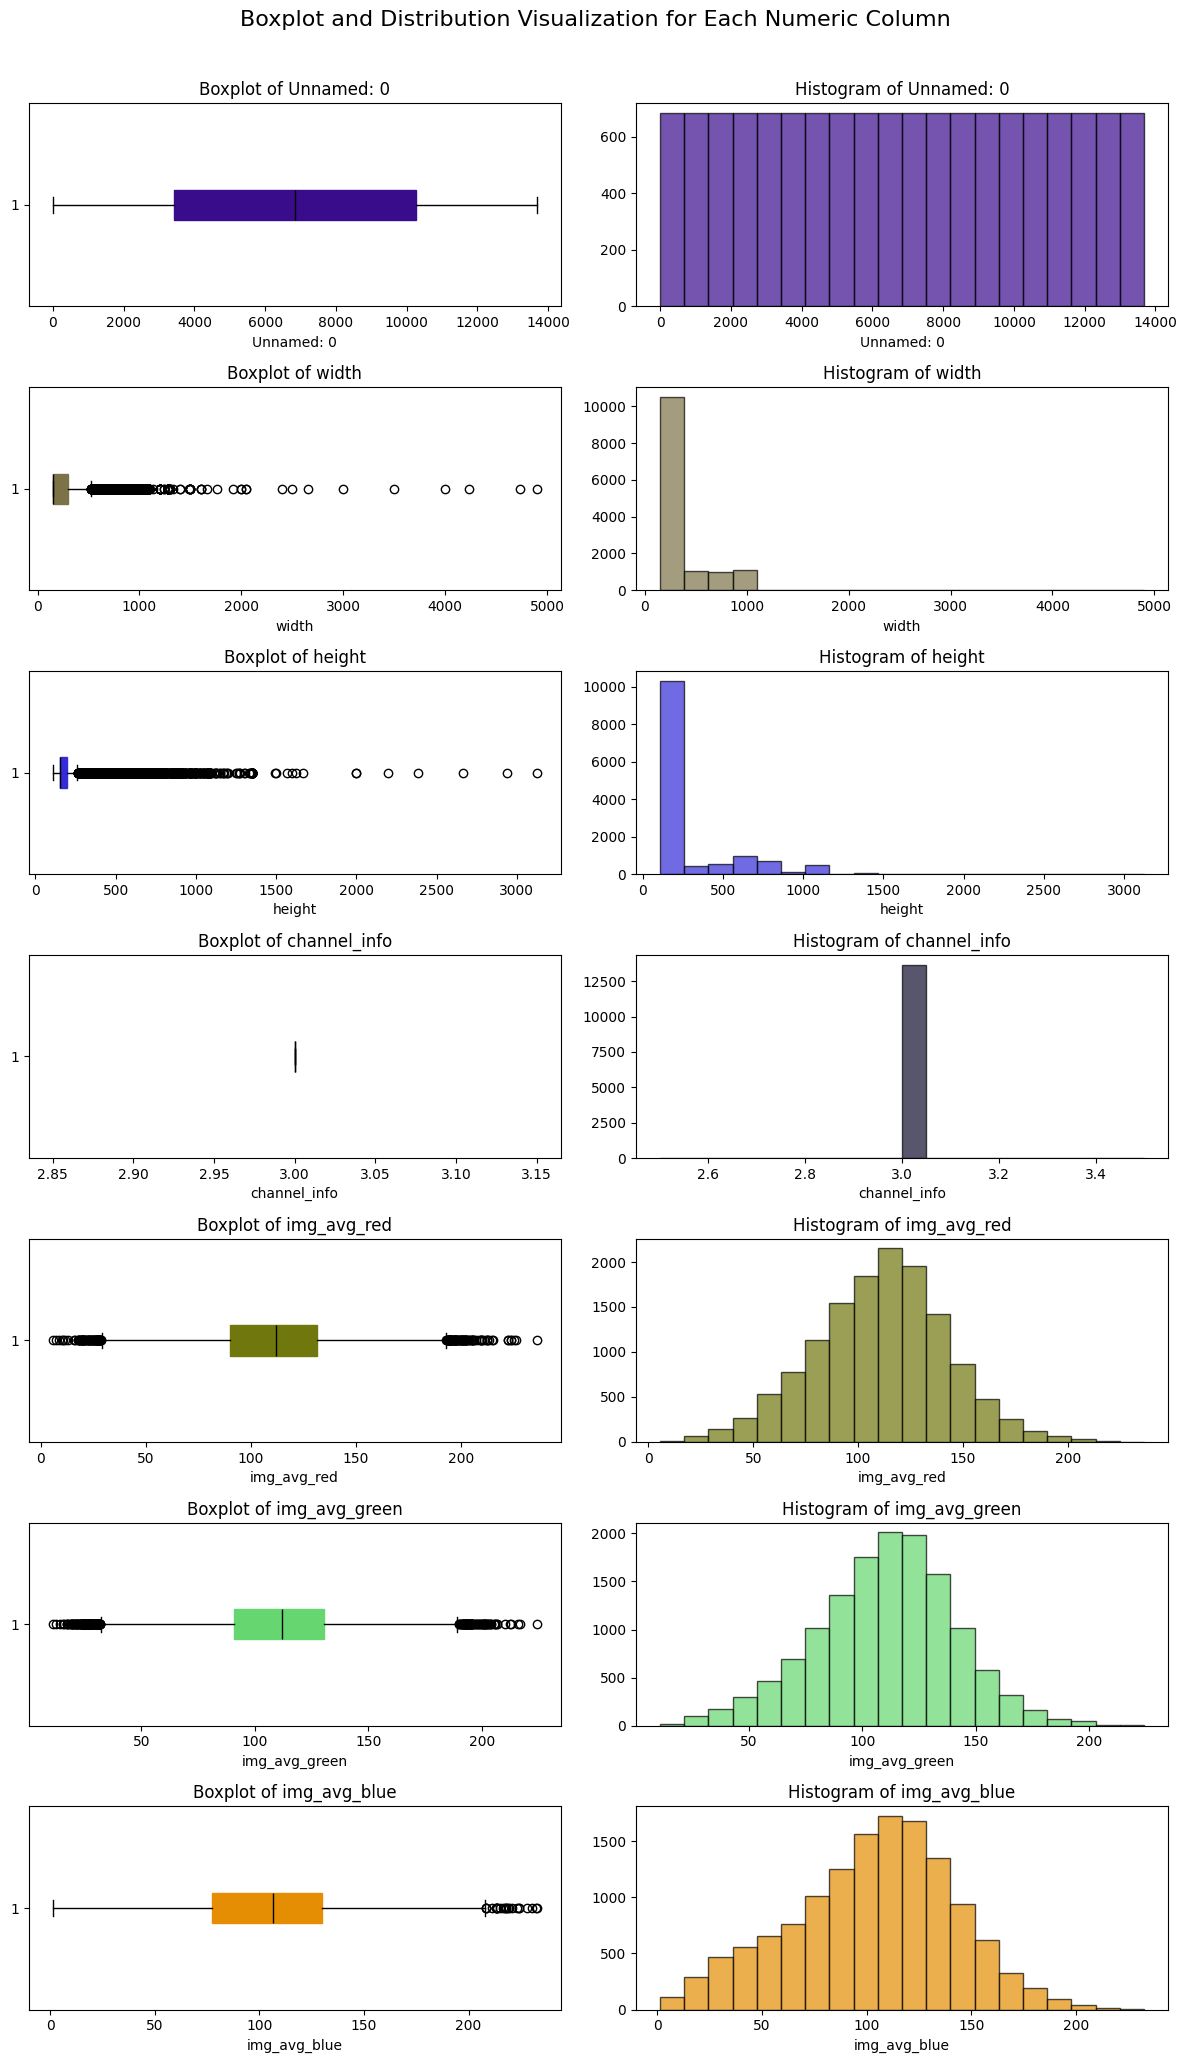

In [15]:
numeric_dist_plot(numeric_data)

### Basic Statistical Calculations

In [16]:
height_statistical_summary = numeric_data["height"].describe()
height_statistical_summary["Variance"] = np.square(np.std(numeric_data["height"]))
height_statistical_summary

,height
count,13674.000000
mean,284.032763
std,262.402847
min,108.000000
25%,150.000000
50%,150.000000
75%,195.000000
max,3123.000000
Variance,68850.218467


In [17]:
width_statistical_summary = numeric_data["width"].describe()
width_statistical_summary["Variance"] = np.square(np.std(numeric_data["width"]))
width_statistical_summary

,width
count,13674.000000
mean,312.385330
std,301.075420
min,150.000000
25%,150.000000
50%,150.000000
75%,300.000000
max,4898.000000
Variance,90639.779194


After examining the statistical calculations, there are some key findings:
| Feature        | What does it tell us                          | Possible Action                                        |
| -------------- | --------------------------------------------- | ------------------------------------------------------ |
| Min / Max      | The images varies wildly in resolution        | Resize or pad all images to a common size              |
| Mean & Median  | Distribution is right-skewed (few big images) | Avoid using mean to choose resize size                 |
| High Std Dev   | Dataset lacks uniformity in image dimensions  | Standardize image dimensions before feeding into a CNN  by resizing|

Resizing images to the dataset's mean height and width (284 and 312 respectively) can lead to larger input dimensions, which may increase model complexity, training time, and memory usage. Instead, resizing images to a standard input size like 224×224 is more efficient and commonly used in deep learning. When combined with image augmentation techniques, this approach helps create a robust model that generalizes well without significantly increasing computational cost.

### Plotting Categorical Data

In [18]:
categorical_data = img_df.select_dtypes(exclude=[np.number])
print(categorical_data.columns)

Index(['image_path', 'label'], dtype='object')


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

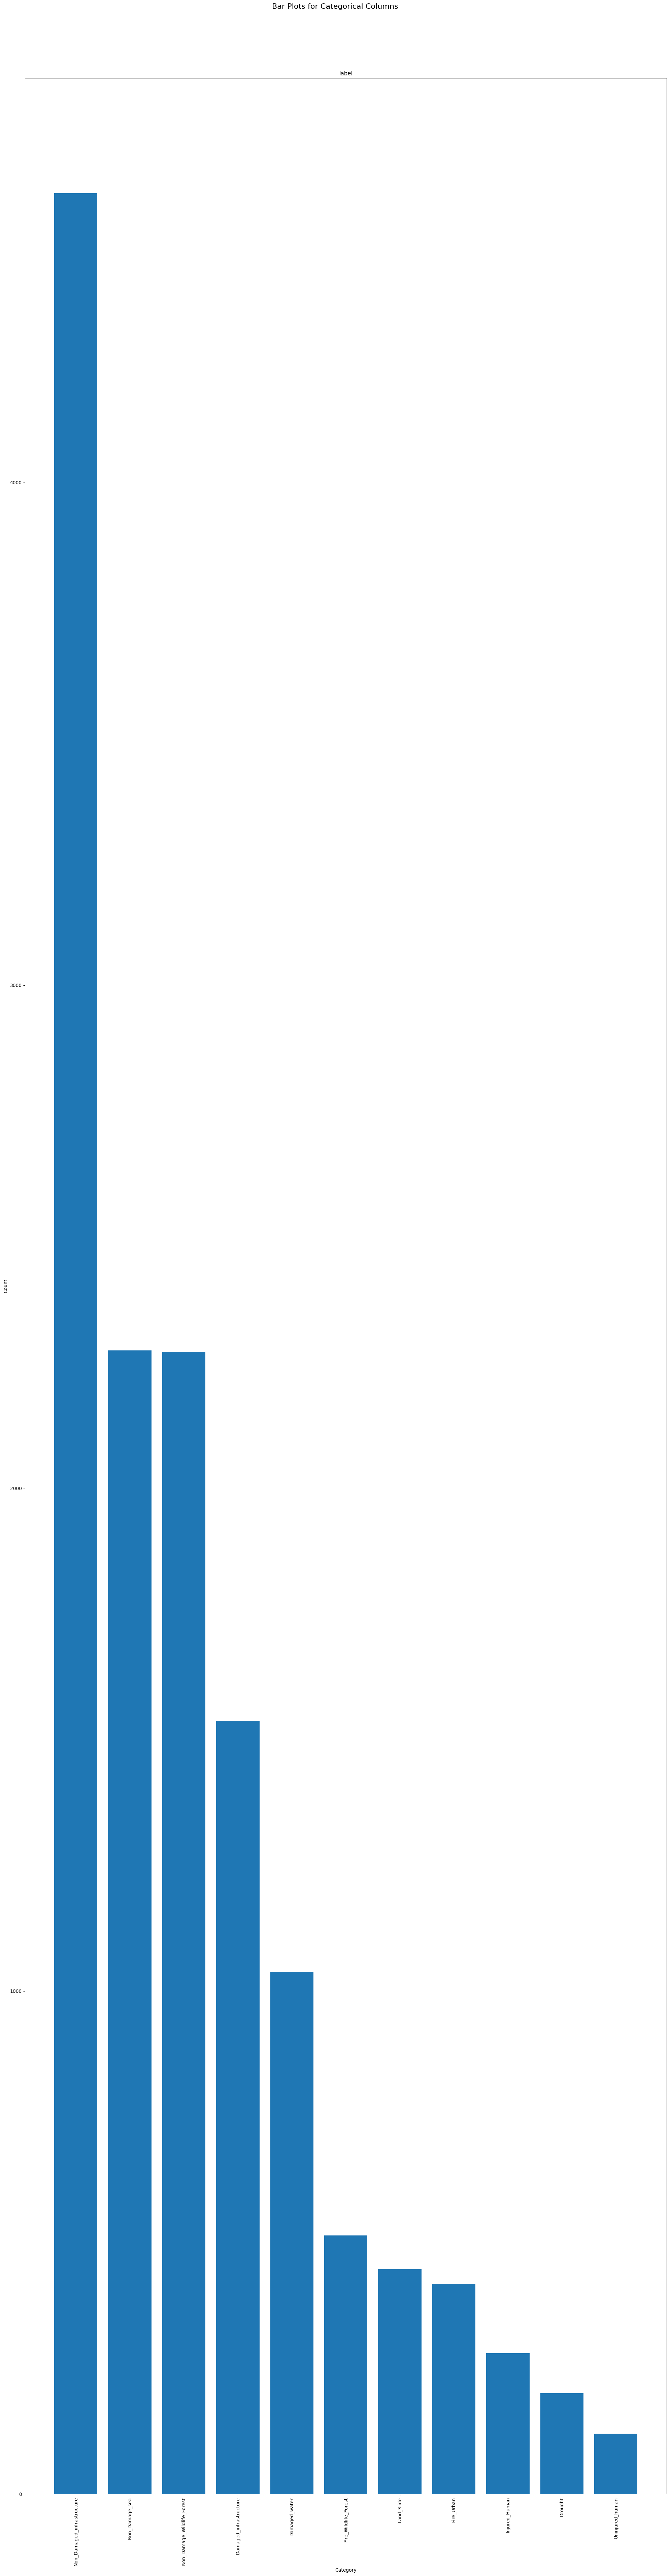

In [19]:
categoric_dist_plot(categorical_data[["label"]]) #the image_path isnt important so we will just plot the label distributions

## Data preprocessing

In [20]:
def create_datasets(df: pd.DataFrame, test_size: float = 0.2, val_size: float = 0.15):
    """
    Create train, validation, and test datasets.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
    """
    # Splitting the data into train and temp (which will be further split into validation and test)
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['label'], random_state=42) #stratify is used to ensure that the same proportion of each class is present in both the training and test sets

    # Splitting train into validation and test sets
    train_df, val_df = train_test_split(train_df, test_size=val_size, stratify=train_df['label'], random_state=42)

    # Make empty directories for the data
    data_path = "/content/drive/MyDrive/project_Disaster classification/data/"

    ## path to destination folders
    train_folder = os.path.join(data_path, 'train')
    val_folder = os.path.join(data_path, 'validation')
    test_folder = os.path.join(data_path, 'test')

    if os.path.exists(train_folder) and os.path.exists(val_folder) and os.path.exists(test_folder):
        print("📦 Cached dataset directories found, skipping copying.")
        # Optionally: load the split info from saved CSVs
        train_df = pd.read_csv(os.path.join(data_path, "train_split.csv"))
        val_df = pd.read_csv(os.path.join(data_path, "val_split.csv"))
        test_df = pd.read_csv(os.path.join(data_path, "test_split.csv"))
        return train_df, val_df, test_df

    ## Create the directories
    for folder_path in [train_folder, val_folder, test_folder]:
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

    # Copy Images
    ## Train Images
    for img_path in tqdm(train_df['image_path'], desc="Copying Train Images"): #tqdm is used to show the progress bar
        label, filename = img_path.split("/")[-2:]
        dest_dir = os.path.join(train_folder, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(dest_dir, filename))

    ## Test Images
    for img_path in tqdm(test_df['image_path'], desc="Copying Test Images"): #tqdm is used to show the progress bar
        label, filename = img_path.split("/")[-2:]
        dest_dir = os.path.join(test_folder, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(dest_dir, filename))

    ## Validation Images
    for img_path in tqdm(val_df['image_path'], desc="Copying Validatioin Images"): #tqdm is used to show the progress bar
        label, filename = img_path.split("/")[-2:]
        dest_dir = os.path.join(val_folder, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(dest_dir, filename))

    # Save CSVs for caching next time
    train_df.to_csv(os.path.join(data_path, "train_split.csv"), index=False)
    val_df.to_csv(os.path.join(data_path, "val_split.csv"), index=False)
    test_df.to_csv(os.path.join(data_path, "test_split.csv"), index=False)

    return train_df, val_df, test_df

In [21]:
train_df, val_df, test_df = create_datasets(img_df)

Copying Train Images:  47%|████▋     | 4386/9298 [1:35:37<1:47:05,  1.31s/it]


KeyboardInterrupt: 

## Data Preperation for Training

We compute the average and standard deviation of the red, green, and blue channels from the training dataset to normalize the images. This helps improve training stability and performance, and avoids introducing bias from the validation or test sets, ensuring that normalization reflects only the distribution the model learns from.

In [ ]:
avg_red = np.average(train_df["img_avg_red"])/255 #devide by 255 to normalize it since by using transform.ToTensor() lateron will normalize the image too
avg_green = np.average(train_df["img_avg_green"])/255
avg_blue = np.average(train_df["img_avg_blue"])/255

std_red = np.std(train_df["img_avg_red"])/255
std_green = np.std(train_df["img_avg_green"])/255
std_blue = np.std(train_df["img_avg_blue"])/255

print("avg_red: ", avg_red)
print("avg_green: ", avg_green)
print("avg_blue: ", avg_blue)

print("Standard Deviation red: ", std_red)
print("Standard Deviation red: ", std_green)
print("Standard Deviation red: ", std_blue)

### Image Augmentation

In [ ]:
transform = transforms.Compose([
    # Resize the image
    transforms.Resize((224, 224)),
    # Image augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    transforms.RandomAutocontrast(),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    # Normalize the data
    transforms.ToTensor(), # Converts image to tensor and scales [0, 255] to [0.0, 1.0]
    transforms.Normalize(
        mean=[avg_red, avg_green, avg_blue],
        std=[std_red, std_green, std_blue]
    )# Standardizes using mean and std (usually to a mean of 0)
])


## Building Model

### Data Loader

In [ ]:
# Ignore currpted files
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the dataset
train_dataset = ImageFolder("/content/drive/MyDrive/project_Disaster classification/data/train", transform=transform)
validation_dataset = ImageFolder("/content/drive/MyDrive/project_Disaster classification/data/validation", transform=transform)
test_dataset = ImageFolder("/content/drive/MyDrive/project_Disaster classification/data/test", transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Gridsearch Setup

Continue adding the activation function

In [ ]:
def define_model(trial, n_output):
    """
    Build a CNN model architecture with hyperparameters tuned by Optuna.

    Parameters:
    -----------
    trial : optuna.trial.Trial
        An Optuna Trial object used to suggest hyperparameters.
    n_output : int
        Number of output neurons/classes for the final layer.

    Returns:
    --------
    nn.Sequential
        A PyTorch Sequential model composed of convolutional and dense layers,
        with hyperparameters sampled from the trial.

    Pruned Trials:
    --------------
        1. Due to a spatial size smaller than 4
        2. Due to number of trainable parameters exceeds 10 million
    """

    # === Model Building Functions ===
    ## Convolution layer builder
    def conv_block_builder(in_channels, out_channels, layer_prefix):
        """
        This function builds a Convolution layer block. and automatically appends each new layer to the neural network array. This function also updates the spatial_size where it will be used as the number of input in the dense layer.

        Each convolution block contains:
        --------------------------------
            1. Convolution layer
            2. Activation function
            3. Dropout (may be included)
            4. Pooling layer (may be included)

        Returns:
        --------
        number of output_channels of the current block for the  next convolution block input_channels
        """
        nonlocal spatial_size # nonlocal so that it can update the variables in the nearest enclosing function.
        # The convolution layer parameters
        kernel_size = trial.suggest_int(f"{layer_prefix}_kernel_size", 3, 9)
        stride = trial.suggest_categorical(f"{layer_prefix}_stride", [1, 2])
        padding = trial.suggest_int(f"{layer_prefix}_padding", 0, 1)

        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        )

        # Convolution layer activation function
        activation_name = trial.suggest_categorical(f"{layer_prefix}_activation_function", ["relu", "leaky_relu", "gelu"])
        activation_function = {
            "relu": nn.ReLU(),
            "leaky_relu": nn.LeakyReLU(),
            "gelu" : nn.GELU()
        }.get(activation_name)

        layers.append(activation_function)

        # Update spatial size
        spatial_size = math.floor(((spatial_size + 2 * padding - kernel_size) / stride) + 1)

        # Add drop out rate so that it reduces overfitting and improve generlization
        dropout_rate = trial.suggest_float(f"{layer_prefix}_dropout_rate", 0.0, 0.5)
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))

        # Pooling layers
        if trial.suggest_categorical(f"{layer_prefix}_max_pooling", [0, 1]) == 1:
            pool_size = trial.suggest_int(f"{layer_prefix}_max_pooling_size", 2, 3)
            layers.append(nn.MaxPool2d(pool_size, pool_size, 0))
            spatial_size = math.floor(((spatial_size - pool_size) / pool_size) + 1)

        return out_channels  # Return new output channels

    ## Dense layer builder
    def dense_layer_builder(layer_prefix):
        """
        This function builds a Dense layer block and automatically appends each new layer to the neural network array.

        Each dense block contains:
        --------------------------------
            1. Linear layer
            2. Activation function
            3. Dropout layer
        """
        nonlocal input_size

        # Dense layer parameters
        out_size = trial.suggest_int(f"{layer_prefix}_output_size", 32, 512)
        layers.append(nn.Linear(input_size, out_size))

        # Dense layer activation functions
        activation_name = trial.suggest_categorical(f"{layer_prefix}_activation_function", ["relu", "leaky_relu"])
        activation_function = {
            "relu": nn.ReLU(),
            "leaky_relu": nn.LeakyReLU()
        }.get(activation_name)

        layers.append(activation_function)

        # Add drop out rate so that it reduces overfitting and improve generlization
        dropout_rate = trial.suggest_float(f"{layer_prefix}_dropout_rate", 0.0, 0.5)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        input_size = out_size # Update input size for the next dense layer based on the output size of this one

    # === Constructing the model ===
    ## Number of layers
    n_layers = trial.suggest_int("n_conv_layers", 1, 9)
    layers = []

    ## Input Layer
    spatial_size = 224
    input_channels = 3
    output_channels = trial.suggest_categorical("INPUT_L_n_output_channels", [4, 8, 16, 32, 64])

    ## Input Layer
    input_channels = conv_block_builder(input_channels, output_channels, "INPUT_L")

    ## Convolution layer
    for i in range(n_layers):
        # Define possible output channels based on previous number output channels
        channel_choices = [4, 8, 16, 32, 64, 128, 256]

        new_output_channels = trial.suggest_categorical(f"L{i}_n_output_channels", channel_choices)
        input_channels = conv_block_builder(input_channels, new_output_channels, f"L{i}")
        output_channels = new_output_channels

        if spatial_size < 4:
            print(f"[Trial {trial.number}] Pruned due to spatial size ({spatial_size}) at layer {i}.")
            raise TrialPruned()  # skip this trial entirely if the spatial size is too small


    # Flatten the layers
    layers.append(
        nn.Flatten()
    )

    input_size = input_channels * spatial_size * spatial_size

    # Dense Layers
    n_dense_layers = trial.suggest_int("n_dense_layer", 1, 15)

    # Hidden layers
    for i in range(n_dense_layers):
        dense_layer_builder(f"dense_{i}") # input_size is updated in each iteration

    # Output layer
    layers.append(
        nn.Linear(input_size, n_output) # No activation function here — nn.CrossEntropyLoss() already applies LogSoftmax internally
    )

    model = nn.Sequential(*layers) # The * takes each layer from the list and passes them one by one to nn.Sequential, instead of giving it the whole list as one big chunk

    # Model parameter limit (optional)
    # # Check if the number of parameters exceeds 10 million
    # total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # # p.numel() returns the total number of elements in the tensor (e.g., weight matrix or bias vector).
    # # We only count parameters with requires_grad=True, (i.e. parameters that will be updated during training).
    # if total_trainable_params > 10000000:
    #     print(f"[Trial {trial.number}] Pruned due to too many parameters: {total_trainable_params}")
    #     raise TrialPruned()

    return model

### Gridsearch Objective

Here we define the optimizers and learning rate to train the model. The chosen optimizers are `Adam`, `SGD with Momentum`, and `FTRL`, as they showed promising performance based on the visualization by (j-w-yun, 2018, optimizer-visualization, https://github.com/j-w-yun/optimizer-visualization.git).

However, since `FTRL` is not available in PyTorch, we will replace it with `AdamW`, which is considered an improved version of Adam. AdamW decouples weight decay from the gradient update step—rather than adding weight decay to the loss function, it applies it directly during parameter updates. This leads to more consistent regularization and often better generalization performance <a href="https://yassin01.medium.com/adam-vs-adamw-understanding-weight-decay-and-its-impact-on-model-performance-b7414f0af8a1">(Yassin, 2024)</a>.


In [ ]:
def objective(trial, n_output, train_loader, val_loader, epochs, device):
    # Reset the seed for each trial of the gridsearch
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # Parameters for early stopping
    best_f1 = 0 # Inital f1 score
    patience = 3 # number of epochs to wait without improvement before stopping
    epochs_no_improve = 0 # Epochs counter without improvement
    best_model_state = None # To store the best model weights

    # Model Initialization
    model = define_model(trial, n_output).to(device)

    # Optimizer Set-Up
    optimizer_name = trial.suggest_categorical("Optimizer", ["Adam", "Momentum", "AdamW"])

    # Learning rate
    lr = trial.suggest_float("Learning_rate", 1e-5, 1e-1, log=True)  # log-scale search

    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=lr),
        "Momentum": optim.SGD(model.parameters(),
                              lr=lr,
                              momentum=trial.suggest_float("sgd_momentum", 1e-5, 1, log=True)),
        "AdamW": optim.AdamW(model.parameters(),
                             lr=lr,
                             weight_decay=trial.suggest_float("adamw_weight_decay", 1e-5, 1, log=True))
    }[optimizer_name]

    # Loss function
    loss_function = nn.CrossEntropyLoss() # Categorical cross entropy

    for epoch in tqdm(range(epochs), desc="Training model..."):
        # Training loop
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Set the device to train on

            optimizer.zero_grad() # Resets all the gradients since pytorch accumulates gradients from previous training
            outputs = model(inputs) # Runs a forward pass
            loss = loss_function(outputs, labels) # Calculates the error
            loss.backward() # Runs a Backward pass
            optimizer.step() # Updates model trainable parameters

        # Early Stopping Check
        # Validation (after training loop finishes)
        model.eval() # Make model in evaluation mode
        all_preds = [] # For the model predictions and true lables
        all_labels = []

        with torch.no_grad(): # Turns off gradient tracking for speeding up validation, saves memory, lock memory weights
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device) # move lables to the device
                outputs = model(inputs) # Pass input data to the model to get raw logits
                _, predicted = torch.max(outputs, 1) # gets the predicted values. Since torch.max outputs max_values(confidence), and predictions

                all_preds.extend(predicted.cpu().numpy()) # move the predictions and lables to the cpu since numpy only works on CPU memory. then convert to numpy arrays then append to the list.
                all_labels.extend(labels.cpu().numpy())

        # Calculate F1 Score
        f1 = f1_score(all_labels, all_preds, average="weighted") # Calculate f1 score weighted since there are class imbalances

        if f1 > best_f1:
            best_f1 = f1
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict()) # Save the model state
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # Validation (after training loop finishes)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Return the F1 score
    f1 = f1_score(all_labels, all_preds, average="weighted")
    print(f"Trial {trial.number}: F1 Score = {f1:.4f}") #for easier logging

    # Save best model to trial
    # Save best model to trial attributes
    trial.set_user_attr("best_model_state", model.state_dict())

    return f1


### Initiate the gridsearch

In [ ]:
# Get number of outputs
n_output = len(img_df["label"].unique())
epochs = 10
n_trials = 100

samplers = optuna.samplers.TPESampler(n_startup_trials=20) # Bayesian optimization method used by Optuna to sample hyperparameters intelligently (20 random trials first before starting the Bayesian optimization.)
study = optuna.create_study(direction="maximize", sampler=samplers) # Maximize f1 score

study.optimize(lambda trial: objective(trial, n_output, train_loader, validation_loader, epochs, device), n_trials=n_trials, timeout=5000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED]) # get the pruned trials
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]) # get the succeeded trials

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

# Define model with best params
best_trial = study.best_trial
best_model = define_model(best_trial, n_output).to(device)
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Load best weights
best_model.load_state_dict(best_trial.user_attrs["best_model_state"])

## Model Evaluation

### Build Best Model

In [ ]:
# Recreate model architecture and load weights
model = define_model(best_trial, n_output)
model.to(device)
model.eval()